In [ ]:
#!pip install -q segmentation-models-pytorch==0.3.0 tifffile imagecodecs
#!pip install -q albumentations==1.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 6.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# CELL 1 — mount drive + imports


import os, gc, time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import KFold
from tqdm.auto import tqdm
import pandas as pd

print("Imports done.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Imports done.


In [ ]:
# CELL 2 — configuration (edit if needed)
ROOT = "/content/drive/MyDrive"
GEOTILE_DIR = os.path.join(ROOT, "geotile")   # your folder
X_PATH = os.path.join(GEOTILE_DIR, "X_train_tiles.npy")
Y_PATH = os.path.join(GEOTILE_DIR, "Y_train_tiles.npy")

# Training hyperparams
NUM_FOLDS = 5           # you chose 5
NUM_EPOCHS = 30         # adjust if you want longer training
BATCH_SIZE = 4          # try 2 if GPU memory is tight
LR = 1e-4

# DataLoader workers (0 is safest on Colab; 1-2 usually ok)
NUM_WORKERS = 1

# Device and AMP scaler
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# Sanity checks
assert os.path.exists(X_PATH), f"X file not found: {X_PATH}"
assert os.path.exists(Y_PATH), f"Y file not found: {Y_PATH}"

print("Paths OK:", X_PATH, Y_PATH)

Device: cuda
Paths OK: /content/drive/MyDrive/geotile/X_train_tiles.npy /content/drive/MyDrive/geotile/Y_train_tiles.npy


In [ ]:
# CELL 3 — Lazy dataset (uses numpy memmap; does not load full arrays into RAM)

# We'll use np.load(..., mmap_mode='r') for memory mapping
X_mem = np.load(X_PATH, mmap_mode='r')
Y_mem = np.load(Y_PATH, mmap_mode='r')

print("Memory-mapped shapes:", X_mem.shape, Y_mem.shape)
N_TILES = X_mem.shape[0]

# Augmentations (strong but stable)
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.25),
    A.GaussNoise(var_limit=(10.0,50.0), p=0.25),
    A.RandomGamma(p=0.25),
    A.ElasticTransform(alpha=50, sigma=5, alpha_affine=10, p=0.2),
    ToTensorV2()
])

valid_transform = A.Compose([
    ToTensorV2()
])

class LazyTilesDataset(Dataset):
    """
    idxs: list/array of indices (into the memmaps)
    mode: 'train' or 'val' for augmentation choice
    """
    def __init__(self, idxs, mode="train"):
        self.idxs = np.array(idxs, dtype=np.int64)
        self.mode = mode

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, i):
        idx = int(self.idxs[i])
        img = X_mem[idx]   # memmap slice -> numpy array view
        msk = Y_mem[idx]

        # Normalize / convert types:
        # imgs may be uint8; convert to float32 and scale to [0,1]
        # albumentations expects HWC uint8 often, but ToTensorV2 can handle float too.
        if img.dtype != np.uint8 and img.dtype != np.float32:
            img = img.astype(np.float32)
        if img.dtype == np.uint8:
            # pass as uint8 to augmentations (they are built for that)
            pass
        else:
            # if float32 but not 0-255, scale via max 255
            img = (img / max(255.0, img.max())) * 255.0
            img = img.astype(np.uint8)

        # Mask handling: ensure single channel uint8 0/255 or 0/1
        if msk.ndim == 3 and msk.shape[2] > 1:
            msk = msk[..., 0]
        if msk.dtype != np.uint8:
            # assume values 0/1 or 0/255 -> convert to 0/255 uint8
            msk = (msk > 0).astype(np.uint8) * 255
        msk = msk.astype(np.uint8)

        if self.mode == "train":
            augmented = train_transform(image=img, mask=msk)
        else:
            augmented = valid_transform(image=img, mask=msk)

        img_t = augmented["image"].float() / 255.0      # Tensor C,H,W in [0,1]
        mask_t = augmented["mask"].unsqueeze(0).float() / 255.0  # 1,H,W in {0,1}

        return img_t, mask_t

print("Dataset class ready. Example N_TILES:", N_TILES)

Memory-mapped shapes: (587, 512, 512, 3) (587, 512, 512, 1)
Dataset class ready. Example N_TILES: 587


/usr/local/lib/python3.12/dist-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


In [ ]:
# CELL 4 — model, loss, metrics (OOM-safe)
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

class UNetWithDropout(nn.Module):
    def __init__(self, backbone="resnet34", dropout=0.3):
        super().__init__()
        self.net = smp.Unet(
            encoder_name=backbone,
            encoder_weights="imagenet",
            in_channels=3,
            classes=1
        )
        self.dropout = nn.Dropout2d(dropout)

    def forward(self, x):
        feats = self.net.encoder(x)
        dec = self.net.decoder(*feats)
        dec = self.dropout(dec)
        return self.net.segmentation_head(dec)

def make_model(backbone="resnet34", dropout=0.3):
    model = UNetWithDropout(backbone=backbone, dropout=dropout)
    return model.to(DEVICE)

# Combined loss (Dice + Focal + optional Tversky)
dice_loss = smp.losses.DiceLoss(mode="binary")
focal_loss = smp.losses.FocalLoss(mode="binary")
tversky_loss = smp.losses.TverskyLoss(mode="binary", alpha=0.7, beta=0.3)

def loss_fn(pred, tgt):
    # pred = logits; most smp losses accept logits directly
    return 0.5 * dice_loss(pred, tgt) + 0.2 * focal_loss(pred, tgt) + 0.3 * tversky_loss(pred, tgt)

# AMP scaler
scaler = GradScaler()

# OOM-safe metric accumulators (use integers)
def batch_confusion_counts(pred_logits, targets, thresh=0.5):
    """
    Returns tp, fp, tn, fn (ints) computed on CPU numpy to avoid GPU OOM.
    pred_logits: torch tensor (B,1,H,W)
    targets: torch tensor (B,1,H,W)
    """
    with torch.no_grad():
        probs = torch.sigmoid(pred_logits).cpu().numpy()
        preds = (probs > thresh).astype(np.uint8)
        t = targets.cpu().numpy().astype(np.uint8)

        # ensure shapes
        preds = preds.reshape(preds.shape[0], -1)
        t = t.reshape(t.shape[0], -1)

        # vectorized sums
        tp = int(((preds == 1) & (t == 1)).sum())
        fp = int(((preds == 1) & (t == 0)).sum())
        tn = int(((preds == 0) & (t == 0)).sum())
        fn = int(((preds == 0) & (t == 1)).sum())

    return tp, fp, tn, fn

def compute_metrics_from_counts(tp, fp, tn, fn):
    eps = 1e-7
    accuracy = (tp + tn) / (tp + tn + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = (2 * precision * recall) / (precision + recall + eps)
    iou = tp / (tp + fp + fn + eps)
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    specificity = tn / (tn + fp + eps)
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "IoU": iou,
        "Dice": dice,
        "Specificity": specificity
    }

print("Model/loss/metrics ready.")

Model/loss/metrics ready.


/tmp/ipython-input-607755156.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
# CELL 5 — helpers: train_one_epoch and validate_one_epoch

def train_one_epoch(model, loader, optimizer, epoch, scaler):
    model.train()
    running_loss = 0.0
    total_tp = total_fp = total_tn = total_fn = 0

    pbar = tqdm(loader, desc=f"Train E{epoch}", leave=False)
    for xb, yb in pbar:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)

        optimizer.zero_grad()
        with autocast():
            logits = model(xb)
            loss = loss_fn(logits, yb)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * xb.size(0)

        # accumulate confusion counts on CPU
        tp, fp, tn, fn = batch_confusion_counts(logits, yb, thresh=0.5)
        total_tp += tp; total_fp += fp; total_tn += tn; total_fn += fn

        pbar.set_postfix(loss=loss.item())

    n_samples = len(loader.dataset)
    avg_loss = running_loss / (n_samples + 1e-9)
    metrics = compute_metrics_from_counts(total_tp, total_fp, total_tn, total_fn)
    return avg_loss, metrics

def validate_one_epoch(model, loader):
    model.eval()
    running_loss = 0.0
    total_tp = total_fp = total_tn = total_fn = 0

    pbar = tqdm(loader, desc="Val", leave=False)
    with torch.no_grad():
        for xb, yb in pbar:
            xb = xb.to(DEVICE, non_blocking=True)
            yb = yb.to(DEVICE, non_blocking=True)

            with autocast():
                logits = model(xb)
                loss = loss_fn(logits, yb)

            running_loss += loss.item() * xb.size(0)

            tp, fp, tn, fn = batch_confusion_counts(logits, yb, thresh=0.5)
            total_tp += tp; total_fp += fp; total_tn += tn; total_fn += fn

    n_samples = len(loader.dataset)
    avg_loss = running_loss / (n_samples + 1e-9)
    metrics = compute_metrics_from_counts(total_tp, total_fp, total_tn, total_fn)
    return avg_loss, metrics

In [ ]:
# CELL 6 — K-Fold training (this will run training & validation across folds)
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

results = []   # store per-fold metrics

for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(N_TILES)), start=1):
    print(f"\n========== Fold {fold} / {NUM_FOLDS} ==========")

    # Datasets & loaders (lazy)
    train_ds = LazyTilesDataset(train_idx, mode="train")
    val_ds   = LazyTilesDataset(val_idx, mode="val")

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=True)

    # Model, optimizer, scheduler, scaler (fresh per fold)
    model = make_model(backbone="resnet34", dropout=0.3)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=3, factor=0.5)
    scaler = GradScaler()

    best_val_loss = 1e9
    fold_history = []

    for epoch in range(1, NUM_EPOCHS + 1):
        t0 = time.time()
        train_loss, train_metrics = train_one_epoch(model, train_loader, optimizer, epoch, scaler)
        val_loss, val_metrics = validate_one_epoch(model, val_loader)
        scheduler.step(val_loss)

        elapsed = time.time() - t0
        print(f"Fold{fold} Epoch {epoch}/{NUM_EPOCHS} - "
              f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} time={elapsed:.1f}s")
        print("  Train IoU:{:.4f} Dice:{:.4f} | Val IoU:{:.4f} Dice:{:.4f}".format(
            train_metrics["IoU"], train_metrics["Dice"],
            val_metrics["IoU"], val_metrics["Dice"]
        ))

        fold_history.append({
            "fold": fold, "epoch": epoch,
            "train_loss": train_loss, **{f"train_{k}": v for k,v in train_metrics.items()},
            "val_loss": val_loss,   **{f"val_{k}": v for k,v in val_metrics.items()}
        })

        # Save best model for this fold
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            model_path = os.path.join(GEOTILE_DIR, f"unet_best_fold{fold}.pth")
            torch.save(model.state_dict(), model_path)
            print("  -> Saved best model to", model_path)

    # Save fold summary
    best_epoch = min(fold_history, key=lambda x: x["val_loss"])
    results.append({
        "fold": fold,
        "best_epoch": best_epoch["epoch"],
        "train_loss": best_epoch["train_loss"],
        "val_loss": best_epoch["val_loss"],
        **{f"train_{k}": best_epoch[f"train_{k}"] for k in train_metrics.keys()},
        **{f"val_{k}": best_epoch[f"val_{k}"] for k in val_metrics.keys()}
    })

    # cleanup to avoid memory accumulation across folds
    del model, optimizer, scheduler, scaler, train_loader, val_loader, train_ds, val_ds, fold_history
    gc.collect()
    torch.cuda.empty_cache()
    print("Cleanup done after fold", fold)

# Save aggregated results to CSV
df = pd.DataFrame(results)
csv_path = os.path.join(GEOTILE_DIR, "kfold_summary.csv")
df.to_csv(csv_path, index=False)
print("K-Fold training complete. Summary saved to", csv_path)
print(df)


========== Fold 1 / 5 ==========
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 239MB/s]
/tmp/ipython-input-2950141767.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train E1:   0%|          | 0/118 [00:00<?, ?it/s]

/tmp/ipython-input-595553083.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val:   0%|          | 0/30 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1610, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.12/threading.py", line 1146, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/

Fold1 Epoch 1/30 - train_loss=0.6912 val_loss=0.6048 time=44.5s
  Train IoU:0.1757 Dice:0.2989 | Val IoU:0.4130 Dice:0.5845
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold1.pth


Train E2:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 2/30 - train_loss=0.5558 val_loss=0.4716 time=25.5s
  Train IoU:0.4511 Dice:0.6218 | Val IoU:0.5074 Dice:0.6732
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold1.pth


Train E3:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 3/30 - train_loss=0.4555 val_loss=0.3590 time=28.4s
  Train IoU:0.5028 Dice:0.6691 | Val IoU:0.5820 Dice:0.7357
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold1.pth


Train E4:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 4/30 - train_loss=0.3907 val_loss=0.4411 time=26.8s
  Train IoU:0.5401 Dice:0.7014 | Val IoU:0.3822 Dice:0.5531


Train E5:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 5/30 - train_loss=0.3538 val_loss=0.2697 time=27.5s
  Train IoU:0.5446 Dice:0.7052 | Val IoU:0.6207 Dice:0.7660
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold1.pth


Train E6:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 6/30 - train_loss=0.3223 val_loss=0.2608 time=31.0s
  Train IoU:0.5662 Dice:0.7230 | Val IoU:0.6015 Dice:0.7512
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold1.pth


Train E7:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 7/30 - train_loss=0.3047 val_loss=0.2242 time=25.4s
  Train IoU:0.5721 Dice:0.7278 | Val IoU:0.6420 Dice:0.7820
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold1.pth


Train E8:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 8/30 - train_loss=0.2891 val_loss=0.2109 time=27.5s
  Train IoU:0.5838 Dice:0.7372 | Val IoU:0.6591 Dice:0.7945
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold1.pth


Train E9:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
      File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 9/30 - train_loss=0.2702 val_loss=0.1995 time=31.0s
  Train IoU:0.5947 Dice:0.7458 | Val IoU:0.6648 Dice:0.7987
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold1.pth


Train E10:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 10/30 - train_loss=0.2577 val_loss=0.2648 time=28.7s
  Train IoU:0.6103 Dice:0.7580 | Val IoU:0.5793 Dice:0.7336


Train E11:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 11/30 - train_loss=0.2671 val_loss=0.2075 time=26.4s
  Train IoU:0.5984 Dice:0.7488 | Val IoU:0.6475 Dice:0.7861


Train E12:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 12/30 - train_loss=0.2485 val_loss=0.2479 time=26.4s
  Train IoU:0.6179 Dice:0.7639 | Val IoU:0.5967 Dice:0.7474


Train E13:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 13/30 - train_loss=0.2370 val_loss=0.1723 time=25.4s
  Train IoU:0.6268 Dice:0.7706 | Val IoU:0.6990 Dice:0.8229
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold1.pth


Train E14:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 14/30 - train_loss=0.2409 val_loss=0.1881 time=30.8s
  Train IoU:0.6256 Dice:0.7697 | Val IoU:0.6682 Dice:0.8011


Train E15:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 15/30 - train_loss=0.2398 val_loss=0.2152 time=27.1s
  Train IoU:0.6243 Dice:0.7687 | Val IoU:0.6387 Dice:0.7796


Train E16:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 16/30 - train_loss=0.2353 val_loss=0.1646 time=24.6s
  Train IoU:0.6231 Dice:0.7678 | Val IoU:0.7107 Dice:0.8309
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold1.pth


Train E17:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 17/30 - train_loss=0.2224 val_loss=0.1908 time=27.3s
  Train IoU:0.6425 Dice:0.7823 | Val IoU:0.6656 Dice:0.7992


Train E18:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 18/30 - train_loss=0.2260 val_loss=0.1669 time=25.3s
  Train IoU:0.6365 Dice:0.7779 | Val IoU:0.7042 Dice:0.8264


Train E19:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Fold1 Epoch 19/30 - train_loss=0.2087 val_loss=0.1742 time=32.1s
  Train IoU:0.6517 Dice:0.7891 | Val IoU:0.6875 Dice:0.8148


Train E20:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 20/30 - train_loss=0.2160 val_loss=0.1915 time=28.5s
  Train IoU:0.6409 Dice:0.7811 | Val IoU:0.6669 Dice:0.8001


Train E21:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 21/30 - train_loss=0.2017 val_loss=0.1585 time=28.3s
  Train IoU:0.6635 Dice:0.7977 | Val IoU:0.7099 Dice:0.8303
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold1.pth


Train E22:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 22/30 - train_loss=0.1895 val_loss=0.1749 time=27.7s
  Train IoU:0.6782 Dice:0.8083 | Val IoU:0.6799 Dice:0.8095


Train E23:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 23/30 - train_loss=0.1840 val_loss=0.1728 time=25.3s
  Train IoU:0.6937 Dice:0.8192 | Val IoU:0.6876 Dice:0.8149


Train E24:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 24/30 - train_loss=0.1753 val_loss=0.1405 time=25.8s
  Train IoU:0.7002 Dice:0.8237 | Val IoU:0.7413 Dice:0.8514
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold1.pth


Train E25:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 25/30 - train_loss=0.1716 val_loss=0.1337 time=26.7s
  Train IoU:0.7020 Dice:0.8249 | Val IoU:0.7503 Dice:0.8573
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold1.pth


Train E26:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 26/30 - train_loss=0.1735 val_loss=0.1283 time=28.0s
  Train IoU:0.7054 Dice:0.8272 | Val IoU:0.7585 Dice:0.8627
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold1.pth


Train E27:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 27/30 - train_loss=0.1743 val_loss=0.1426 time=30.0s
  Train IoU:0.7073 Dice:0.8285 | Val IoU:0.7397 Dice:0.8504


Train E28:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 28/30 - train_loss=0.1636 val_loss=0.1220 time=26.0s
  Train IoU:0.7206 Dice:0.8376 | Val IoU:0.7687 Dice:0.8693
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold1.pth


Train E29:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 29/30 - train_loss=0.1637 val_loss=0.1316 time=29.6s
  Train IoU:0.7198 Dice:0.8371 | Val IoU:0.7506 Dice:0.8575


Train E30:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold1 Epoch 30/30 - train_loss=0.1540 val_loss=0.1437 time=27.4s
  Train IoU:0.7273 Dice:0.8421 | Val IoU:0.7320 Dice:0.8453
Cleanup done after fold 1

========== Fold 2 / 5 ==========


Train E1:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 1/30 - train_loss=0.7342 val_loss=0.6859 time=25.8s
  Train IoU:0.1169 Dice:0.2094 | Val IoU:0.3145 Dice:0.4785
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold2.pth


Train E2:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 2/30 - train_loss=0.6561 val_loss=0.6234 time=27.1s
  Train IoU:0.3452 Dice:0.5132 | Val IoU:0.4745 Dice:0.6436
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold2.pth


Train E3:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 3/30 - train_loss=0.6109 val_loss=0.5751 time=28.9s
  Train IoU:0.4491 Dice:0.6198 | Val IoU:0.4653 Dice:0.6351
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold2.pth


Train E4:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 4/30 - train_loss=0.5639 val_loss=0.4979 time=28.7s
  Train IoU:0.4875 Dice:0.6554 | Val IoU:0.5394 Dice:0.7008
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold2.pth


Train E5:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Fold2 Epoch 5/30 - train_loss=0.5176 val_loss=0.4931 time=28.6s
  Train IoU:0.5062 Dice:0.6722 | Val IoU:0.3778 Dice:0.5484
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold2.pth


Train E6:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 6/30 - train_loss=0.4600 val_loss=0.4546 time=29.4s
  Train IoU:0.5252 Dice:0.6887 | Val IoU:0.3562 Dice:0.5253
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold2.pth


Train E7:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 7/30 - train_loss=0.4125 val_loss=0.3532 time=28.5s
  Train IoU:0.5578 Dice:0.7162 | Val IoU:0.5282 Dice:0.6913
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold2.pth


Train E8:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 8/30 - train_loss=0.3830 val_loss=0.2845 time=28.0s
  Train IoU:0.5628 Dice:0.7202 | Val IoU:0.5952 Dice:0.7462
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold2.pth


Train E9:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Fold2 Epoch 9/30 - train_loss=0.3682 val_loss=0.2483 time=36.3s
  Train IoU:0.5711 Dice:0.7270 | Val IoU:0.6376 Dice:0.7787
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold2.pth


Train E10:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 10/30 - train_loss=0.3383 val_loss=0.2327 time=29.5s
  Train IoU:0.5850 Dice:0.7381 | Val IoU:0.6376 Dice:0.7787
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold2.pth


Train E11:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 11/30 - train_loss=0.3105 val_loss=0.2474 time=29.0s
  Train IoU:0.6066 Dice:0.7551 | Val IoU:0.6015 Dice:0.7511


Train E12:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 12/30 - train_loss=0.2965 val_loss=0.2379 time=26.3s
  Train IoU:0.6123 Dice:0.7595 | Val IoU:0.6124 Dice:0.7596


Train E13:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 13/30 - train_loss=0.2714 val_loss=0.1911 time=24.9s
  Train IoU:0.6268 Dice:0.7706 | Val IoU:0.6641 Dice:0.7981
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold2.pth


Train E14:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 14/30 - train_loss=0.2659 val_loss=0.2234 time=31.7s
  Train IoU:0.6254 Dice:0.7696 | Val IoU:0.6354 Dice:0.7771


Train E15:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 15/30 - train_loss=0.2511 val_loss=0.2264 time=26.4s
  Train IoU:0.6258 Dice:0.7698 | Val IoU:0.6142 Dice:0.7610


Train E16:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 16/30 - train_loss=0.2503 val_loss=0.2404 time=26.0s
  Train IoU:0.6320 Dice:0.7745 | Val IoU:0.5980 Dice:0.7484


Train E17:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 17/30 - train_loss=0.2399 val_loss=0.1770 time=26.6s
  Train IoU:0.6456 Dice:0.7846 | Val IoU:0.6807 Dice:0.8100
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold2.pth


Train E18:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 18/30 - train_loss=0.2431 val_loss=0.2135 time=29.8s
  Train IoU:0.6382 Dice:0.7791 | Val IoU:0.6273 Dice:0.7710


Train E19:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Fold2 Epoch 19/30 - train_loss=0.2456 val_loss=0.2124 time=31.9s
  Train IoU:0.6269 Dice:0.7707 | Val IoU:0.6353 Dice:0.7770


Train E20:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 20/30 - train_loss=0.2311 val_loss=0.1963 time=27.0s
  Train IoU:0.6479 Dice:0.7863 | Val IoU:0.6575 Dice:0.7934


Train E21:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 21/30 - train_loss=0.2237 val_loss=0.1805 time=28.2s
  Train IoU:0.6617 Dice:0.7964 | Val IoU:0.6691 Dice:0.8018


Train E22:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 22/30 - train_loss=0.2175 val_loss=0.1998 time=27.8s
  Train IoU:0.6740 Dice:0.8052 | Val IoU:0.6609 Dice:0.7959


Train E23:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 23/30 - train_loss=0.2073 val_loss=0.1630 time=25.7s
  Train IoU:0.6734 Dice:0.8048 | Val IoU:0.6916 Dice:0.8177
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold2.pth


Train E24:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 24/30 - train_loss=0.1975 val_loss=0.1651 time=27.8s
  Train IoU:0.6859 Dice:0.8137 | Val IoU:0.6932 Dice:0.8188


Train E25:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 25/30 - train_loss=0.1912 val_loss=0.1601 time=30.0s
  Train IoU:0.6905 Dice:0.8169 | Val IoU:0.7061 Dice:0.8277
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold2.pth


Train E26:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 26/30 - train_loss=0.1908 val_loss=0.1434 time=29.1s
  Train IoU:0.6948 Dice:0.8199 | Val IoU:0.7316 Dice:0.8450
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold2.pth


Train E27:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 27/30 - train_loss=0.1956 val_loss=0.1329 time=29.1s
  Train IoU:0.7016 Dice:0.8246 | Val IoU:0.7426 Dice:0.8523
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold2.pth


Train E28:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 28/30 - train_loss=0.1877 val_loss=0.1339 time=27.8s
  Train IoU:0.6971 Dice:0.8215 | Val IoU:0.7470 Dice:0.8552


Train E29:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Fold2 Epoch 29/30 - train_loss=0.1776 val_loss=0.1256 time=33.1s
  Train IoU:0.7174 Dice:0.8354 | Val IoU:0.7592 Dice:0.8631
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold2.pth


Train E30:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold2 Epoch 30/30 - train_loss=0.1834 val_loss=0.1475 time=31.5s
  Train IoU:0.7072 Dice:0.8285 | Val IoU:0.7223 Dice:0.8387
Cleanup done after fold 2

========== Fold 3 / 5 ==========


Train E1:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 1/30 - train_loss=0.6607 val_loss=0.5466 time=25.9s
  Train IoU:0.2007 Dice:0.3343 | Val IoU:0.4432 Dice:0.6142
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold3.pth


Train E2:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 2/30 - train_loss=0.5410 val_loss=0.4543 time=26.9s
  Train IoU:0.4362 Dice:0.6075 | Val IoU:0.4962 Dice:0.6633
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold3.pth


Train E3:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 3/30 - train_loss=0.4659 val_loss=0.3467 time=29.5s
  Train IoU:0.4840 Dice:0.6523 | Val IoU:0.5647 Dice:0.7218
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold3.pth


Train E4:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 4/30 - train_loss=0.4085 val_loss=0.2876 time=29.0s
  Train IoU:0.5241 Dice:0.6878 | Val IoU:0.6198 Dice:0.7653
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold3.pth


Train E5:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 5/30 - train_loss=0.3648 val_loss=0.2859 time=28.9s
  Train IoU:0.5542 Dice:0.7131 | Val IoU:0.5704 Dice:0.7265
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold3.pth


Train E6:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 6/30 - train_loss=0.3550 val_loss=0.2434 time=26.8s
  Train IoU:0.5593 Dice:0.7174 | Val IoU:0.6191 Dice:0.7648
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold3.pth


Train E7:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 7/30 - train_loss=0.3226 val_loss=0.2383 time=29.3s
  Train IoU:0.5657 Dice:0.7226 | Val IoU:0.6202 Dice:0.7656
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold3.pth


Train E8:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 8/30 - train_loss=0.3048 val_loss=0.2576 time=30.2s
  Train IoU:0.5755 Dice:0.7306 | Val IoU:0.5886 Dice:0.7410


Train E9:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 9/30 - train_loss=0.2868 val_loss=0.2122 time=24.7s
  Train IoU:0.5852 Dice:0.7383 | Val IoU:0.6361 Dice:0.7776
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold3.pth


Train E10:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 10/30 - train_loss=0.2637 val_loss=0.2031 time=33.6s
  Train IoU:0.6048 Dice:0.7537 | Val IoU:0.6540 Dice:0.7908
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold3.pth


Train E11:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 11/30 - train_loss=0.2720 val_loss=0.2049 time=31.3s
  Train IoU:0.5978 Dice:0.7483 | Val IoU:0.6534 Dice:0.7903


Train E12:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 12/30 - train_loss=0.2566 val_loss=0.2156 time=26.8s
  Train IoU:0.6162 Dice:0.7626 | Val IoU:0.6312 Dice:0.7739


Train E13:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 13/30 - train_loss=0.2398 val_loss=0.1776 time=27.0s
  Train IoU:0.6334 Dice:0.7756 | Val IoU:0.6826 Dice:0.8114
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold3.pth


Train E14:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 14/30 - train_loss=0.2493 val_loss=0.1903 time=29.4s
  Train IoU:0.6208 Dice:0.7660 | Val IoU:0.6703 Dice:0.8026


Train E15:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 15/30 - train_loss=0.2335 val_loss=0.1696 time=31.4s
  Train IoU:0.6307 Dice:0.7735 | Val IoU:0.6945 Dice:0.8197
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold3.pth


Train E16:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 16/30 - train_loss=0.2262 val_loss=0.1665 time=29.9s
  Train IoU:0.6498 Dice:0.7877 | Val IoU:0.6974 Dice:0.8218
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold3.pth


Train E17:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 17/30 - train_loss=0.2320 val_loss=0.1924 time=29.4s
  Train IoU:0.6342 Dice:0.7761 | Val IoU:0.6627 Dice:0.7971


Train E18:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 18/30 - train_loss=0.2241 val_loss=0.1700 time=26.9s
  Train IoU:0.6345 Dice:0.7764 | Val IoU:0.6945 Dice:0.8197


Train E19:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 19/30 - train_loss=0.2105 val_loss=0.1690 time=27.0s
  Train IoU:0.6594 Dice:0.7947 | Val IoU:0.6970 Dice:0.8214


Train E20:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 20/30 - train_loss=0.2184 val_loss=0.1556 time=30.6s
  Train IoU:0.6457 Dice:0.7847 | Val IoU:0.7145 Dice:0.8335
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold3.pth


Train E21:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 21/30 - train_loss=0.2365 val_loss=0.1635 time=30.3s
  Train IoU:0.6263 Dice:0.7702 | Val IoU:0.7039 Dice:0.8262


Train E22:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 22/30 - train_loss=0.2114 val_loss=0.1664 time=27.5s
  Train IoU:0.6525 Dice:0.7897 | Val IoU:0.6932 Dice:0.8188


Train E23:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 23/30 - train_loss=0.2172 val_loss=0.1593 time=27.1s
  Train IoU:0.6494 Dice:0.7875 | Val IoU:0.7124 Dice:0.8321


Train E24:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 24/30 - train_loss=0.1943 val_loss=0.1503 time=27.4s
  Train IoU:0.6763 Dice:0.8069 | Val IoU:0.7190 Dice:0.8365
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold3.pth


Train E25:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 25/30 - train_loss=0.1997 val_loss=0.1443 time=32.3s
  Train IoU:0.6674 Dice:0.8006 | Val IoU:0.7320 Dice:0.8452
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold3.pth


Train E26:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 26/30 - train_loss=0.1896 val_loss=0.1406 time=30.1s
  Train IoU:0.6805 Dice:0.8099 | Val IoU:0.7342 Dice:0.8468
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold3.pth


Train E27:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 27/30 - train_loss=0.2000 val_loss=0.1784 time=28.4s
  Train IoU:0.6730 Dice:0.8046 | Val IoU:0.6851 Dice:0.8131


Train E28:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 28/30 - train_loss=0.2014 val_loss=0.1337 time=27.6s
  Train IoU:0.6620 Dice:0.7967 | Val IoU:0.7449 Dice:0.8538
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold3.pth


Train E29:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Fold3 Epoch 29/30 - train_loss=0.1884 val_loss=0.1689 time=34.6s
  Train IoU:0.6798 Dice:0.8094 | Val IoU:0.6962 Dice:0.8209


Train E30:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold3 Epoch 30/30 - train_loss=0.1912 val_loss=0.1696 time=31.2s
  Train IoU:0.6734 Dice:0.8048 | Val IoU:0.6925 Dice:0.8183
Cleanup done after fold 3

========== Fold 4 / 5 ==========


Train E1:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 1/30 - train_loss=0.6645 val_loss=0.5966 time=27.5s
  Train IoU:0.2470 Dice:0.3962 | Val IoU:0.4098 Dice:0.5814
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold4.pth


Train E2:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 2/30 - train_loss=0.5510 val_loss=0.6173 time=27.9s
  Train IoU:0.4647 Dice:0.6345 | Val IoU:0.2436 Dice:0.3917


Train E3:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 3/30 - train_loss=0.4771 val_loss=0.3998 time=26.2s
  Train IoU:0.5103 Dice:0.6757 | Val IoU:0.5450 Dice:0.7055
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold4.pth


Train E4:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 4/30 - train_loss=0.4096 val_loss=0.3328 time=28.9s
  Train IoU:0.5529 Dice:0.7121 | Val IoU:0.5694 Dice:0.7256
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold4.pth


Train E5:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 5/30 - train_loss=0.3678 val_loss=0.3076 time=27.6s
  Train IoU:0.5662 Dice:0.7230 | Val IoU:0.5614 Dice:0.7191
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold4.pth


Train E6:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 6/30 - train_loss=0.3427 val_loss=0.2882 time=32.6s
  Train IoU:0.5728 Dice:0.7284 | Val IoU:0.5644 Dice:0.7216
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold4.pth


Train E7:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 7/30 - train_loss=0.3152 val_loss=0.2817 time=29.9s
  Train IoU:0.5941 Dice:0.7454 | Val IoU:0.5605 Dice:0.7184
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold4.pth


Train E8:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 8/30 - train_loss=0.2964 val_loss=0.2426 time=26.7s
  Train IoU:0.6033 Dice:0.7526 | Val IoU:0.6070 Dice:0.7554
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold4.pth


Train E9:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 9/30 - train_loss=0.2791 val_loss=0.2072 time=27.9s
  Train IoU:0.6117 Dice:0.7591 | Val IoU:0.6433 Dice:0.7829
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold4.pth


Train E10:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 10/30 - train_loss=0.2737 val_loss=0.2176 time=33.2s
  Train IoU:0.6141 Dice:0.7609 | Val IoU:0.6244 Dice:0.7688


Train E11:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 11/30 - train_loss=0.2652 val_loss=0.2240 time=27.8s
  Train IoU:0.6200 Dice:0.7654 | Val IoU:0.6152 Dice:0.7618


Train E12:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 12/30 - train_loss=0.2591 val_loss=0.2187 time=26.9s
  Train IoU:0.6228 Dice:0.7675 | Val IoU:0.6186 Dice:0.7644


Train E13:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 13/30 - train_loss=0.2615 val_loss=0.1915 time=26.9s
  Train IoU:0.6184 Dice:0.7642 | Val IoU:0.6561 Dice:0.7924
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold4.pth


Train E14:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 14/30 - train_loss=0.2355 val_loss=0.1916 time=28.8s
  Train IoU:0.6386 Dice:0.7794 | Val IoU:0.6561 Dice:0.7923


Train E15:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1

Fold4 Epoch 15/30 - train_loss=0.2472 val_loss=0.1960 time=33.6s
  Train IoU:0.6242 Dice:0.7686 | Val IoU:0.6429 Dice:0.7827


Train E16:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 16/30 - train_loss=0.2277 val_loss=0.1812 time=30.8s
  Train IoU:0.6454 Dice:0.7845 | Val IoU:0.6662 Dice:0.7996
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold4.pth


Train E17:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 17/30 - train_loss=0.2278 val_loss=0.1921 time=31.1s
  Train IoU:0.6571 Dice:0.7931 | Val IoU:0.6517 Dice:0.7891


Train E18:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 18/30 - train_loss=0.2245 val_loss=0.1875 time=25.9s
  Train IoU:0.6415 Dice:0.7816 | Val IoU:0.6582 Dice:0.7939


Train E19:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 19/30 - train_loss=0.2175 val_loss=0.2101 time=25.5s
  Train IoU:0.6654 Dice:0.7991 | Val IoU:0.6244 Dice:0.7688


Train E20:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 20/30 - train_loss=0.2070 val_loss=0.1835 time=27.0s
  Train IoU:0.6672 Dice:0.8004 | Val IoU:0.6650 Dice:0.7988


Train E21:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 21/30 - train_loss=0.1896 val_loss=0.1797 time=33.3s
  Train IoU:0.6964 Dice:0.8211 | Val IoU:0.6709 Dice:0.8030
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold4.pth


Train E22:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 22/30 - train_loss=0.1946 val_loss=0.1510 time=29.1s
  Train IoU:0.6903 Dice:0.8168 | Val IoU:0.7138 Dice:0.8330
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold4.pth


Train E23:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 23/30 - train_loss=0.1773 val_loss=0.1544 time=29.2s
  Train IoU:0.7048 Dice:0.8268 | Val IoU:0.7104 Dice:0.8307


Train E24:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 24/30 - train_loss=0.1848 val_loss=0.1466 time=28.3s
  Train IoU:0.6970 Dice:0.8214 | Val IoU:0.7183 Dice:0.8361
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold4.pth


Train E25:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Fold4 Epoch 25/30 - train_loss=0.1742 val_loss=0.1396 time=30.5s
  Train IoU:0.7142 Dice:0.8333 | Val IoU:0.7319 Dice:0.8452
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold4.pth


Train E26:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 26/30 - train_loss=0.1726 val_loss=0.1335 time=32.0s
  Train IoU:0.7282 Dice:0.8427 | Val IoU:0.7420 Dice:0.8519
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold4.pth


Train E27:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 27/30 - train_loss=0.1791 val_loss=0.1559 time=28.3s
  Train IoU:0.7082 Dice:0.8292 | Val IoU:0.7049 Dice:0.8269


Train E28:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 28/30 - train_loss=0.1635 val_loss=0.1378 time=27.8s
  Train IoU:0.7276 Dice:0.8423 | Val IoU:0.7355 Dice:0.8476


Train E29:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 29/30 - train_loss=0.1561 val_loss=0.1331 time=27.7s
  Train IoU:0.7315 Dice:0.8450 | Val IoU:0.7458 Dice:0.8544
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold4.pth


Train E30:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold4 Epoch 30/30 - train_loss=0.1510 val_loss=0.1250 time=34.9s
  Train IoU:0.7409 Dice:0.8512 | Val IoU:0.7554 Dice:0.8607
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold4.pth
Cleanup done after fold 4

========== Fold 5 / 5 ==========


Train E1:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 1/30 - train_loss=0.6729 val_loss=0.6005 time=27.8s
  Train IoU:0.2079 Dice:0.3443 | Val IoU:0.3317 Dice:0.4982
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold5.pth


Train E2:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 2/30 - train_loss=0.5427 val_loss=0.4680 time=27.0s
  Train IoU:0.4087 Dice:0.5803 | Val IoU:0.4683 Dice:0.6378
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold5.pth


Train E3:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 3/30 - train_loss=0.4625 val_loss=0.3833 time=28.4s
  Train IoU:0.4638 Dice:0.6337 | Val IoU:0.5200 Dice:0.6842
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold5.pth


Train E4:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 4/30 - train_loss=0.4003 val_loss=0.3266 time=29.5s
  Train IoU:0.5086 Dice:0.6743 | Val IoU:0.5492 Dice:0.7090
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold5.pth


Train E5:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 5/30 - train_loss=0.3568 val_loss=0.2769 time=28.5s
  Train IoU:0.5249 Dice:0.6884 | Val IoU:0.5825 Dice:0.7362
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold5.pth


Train E6:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 6/30 - train_loss=0.3200 val_loss=0.2410 time=26.9s
  Train IoU:0.5426 Dice:0.7035 | Val IoU:0.6180 Dice:0.7639
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold5.pth


Train E7:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 7/30 - train_loss=0.3116 val_loss=0.2494 time=30.3s
  Train IoU:0.5498 Dice:0.7095 | Val IoU:0.5971 Dice:0.7477


Train E8:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 8/30 - train_loss=0.2719 val_loss=0.2407 time=27.1s
  Train IoU:0.5767 Dice:0.7315 | Val IoU:0.6044 Dice:0.7534
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold5.pth


Train E9:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 9/30 - train_loss=0.2780 val_loss=0.2265 time=29.2s
  Train IoU:0.5665 Dice:0.7232 | Val IoU:0.6200 Dice:0.7654
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold5.pth


Train E10:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 10/30 - train_loss=0.2707 val_loss=0.2134 time=33.8s
  Train IoU:0.5616 Dice:0.7193 | Val IoU:0.6298 Dice:0.7728
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold5.pth


Train E11:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 11/30 - train_loss=0.2489 val_loss=0.2462 time=29.5s
  Train IoU:0.5895 Dice:0.7418 | Val IoU:0.5837 Dice:0.7372


Train E12:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 12/30 - train_loss=0.2547 val_loss=0.2159 time=27.6s
  Train IoU:0.5704 Dice:0.7264 | Val IoU:0.6260 Dice:0.7700


Train E13:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 13/30 - train_loss=0.2445 val_loss=0.2213 time=27.8s
  Train IoU:0.5823 Dice:0.7360 | Val IoU:0.6120 Dice:0.7593


Train E14:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 14/30 - train_loss=0.2410 val_loss=0.2026 time=27.5s
  Train IoU:0.5863 Dice:0.7392 | Val IoU:0.6378 Dice:0.7789
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold5.pth


Train E15:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 15/30 - train_loss=0.2281 val_loss=0.2021 time=33.8s
  Train IoU:0.6011 Dice:0.7509 | Val IoU:0.6446 Dice:0.7839
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold5.pth


Train E16:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 16/30 - train_loss=0.2184 val_loss=0.2475 time=31.3s
  Train IoU:0.6174 Dice:0.7634 | Val IoU:0.5793 Dice:0.7336


Train E17:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 17/30 - train_loss=0.2332 val_loss=0.1884 time=28.0s
  Train IoU:0.5903 Dice:0.7423 | Val IoU:0.6569 Dice:0.7929
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold5.pth


Train E18:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 18/30 - train_loss=0.2193 val_loss=0.2066 time=30.6s
  Train IoU:0.5963 Dice:0.7471 | Val IoU:0.6447 Dice:0.7840


Train E19:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 19/30 - train_loss=0.2171 val_loss=0.1887 time=28.1s
  Train IoU:0.6029 Dice:0.7523 | Val IoU:0.6594 Dice:0.7947


Train E20:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 20/30 - train_loss=0.2040 val_loss=0.2373 time=33.9s
  Train IoU:0.6430 Dice:0.7827 | Val IoU:0.6026 Dice:0.7520


Train E21:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 21/30 - train_loss=0.2035 val_loss=0.2041 time=28.6s
  Train IoU:0.6216 Dice:0.7666 | Val IoU:0.6495 Dice:0.7875


Train E22:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 22/30 - train_loss=0.1840 val_loss=0.1588 time=27.8s
  Train IoU:0.6593 Dice:0.7946 | Val IoU:0.7031 Dice:0.8257
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold5.pth


Train E23:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 23/30 - train_loss=0.1911 val_loss=0.1866 time=28.8s
  Train IoU:0.6372 Dice:0.7784 | Val IoU:0.6658 Dice:0.7994


Train E24:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 24/30 - train_loss=0.1842 val_loss=0.1616 time=28.3s
  Train IoU:0.6547 Dice:0.7913 | Val IoU:0.6985 Dice:0.8225


Train E25:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Fold5 Epoch 25/30 - train_loss=0.1660 val_loss=0.1570 time=34.5s
  Train IoU:0.6677 Dice:0.8007 | Val IoU:0.7058 Dice:0.8275
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold5.pth


Train E26:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 26/30 - train_loss=0.1797 val_loss=0.1491 time=37.7s
  Train IoU:0.6595 Dice:0.7948 | Val IoU:0.7220 Dice:0.8386
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold5.pth


Train E27:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 27/30 - train_loss=0.1613 val_loss=0.1476 time=30.7s
  Train IoU:0.6865 Dice:0.8141 | Val IoU:0.7214 Dice:0.8382
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold5.pth


Train E28:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 28/30 - train_loss=0.1541 val_loss=0.1396 time=29.5s
  Train IoU:0.6898 Dice:0.8164 | Val IoU:0.7307 Dice:0.8444
  -> Saved best model to /content/drive/MyDrive/geotile/unet_best_fold5.pth


Train E29:   0%|          | 0/118 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c4e97fbcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Fold5 Epoch 29/30 - train_loss=0.1576 val_loss=0.1615 time=35.4s
  Train IoU:0.6943 Dice:0.8195 | Val IoU:0.7031 Dice:0.8257


Train E30:   0%|          | 0/118 [00:00<?, ?it/s]

Val:   0%|          | 0/30 [00:00<?, ?it/s]

Fold5 Epoch 30/30 - train_loss=0.1604 val_loss=0.1734 time=29.7s
  Train IoU:0.6972 Dice:0.8216 | Val IoU:0.6908 Dice:0.8171
Cleanup done after fold 5
K-Fold training complete. Summary saved to /content/drive/MyDrive/geotile/kfold_summary.csv
   fold  best_epoch  train_loss  val_loss  train_Accuracy  train_Precision  \
0     1          28    0.163642  0.122025        0.982837         0.830576   
1     2          29    0.177594  0.125640        0.982699         0.831021   
2     3          28    0.201408  0.133730        0.978809         0.799876   
3     4          30    0.151040  0.125024        0.984402         0.856398   
4     5          28    0.154144  0.139551        0.981631         0.854282   

   train_Recall  train_F1  train_IoU  train_Dice  train_Specificity  \
0      0.844801  0.837628   0.720620    0.837628           0.990470   
1      0.839913  0.835443   0.717391    0.835443           0.990577   
2      0.793465  0.796658   0.662037    0.796658           0.989041   
3   

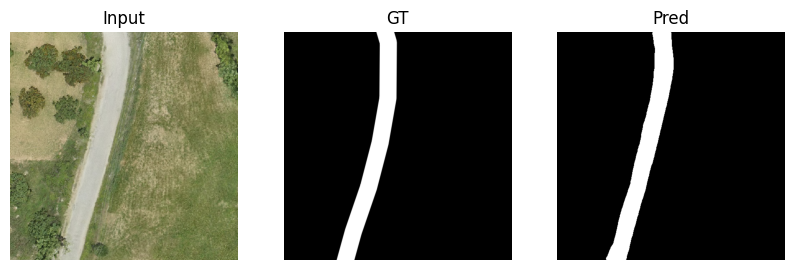

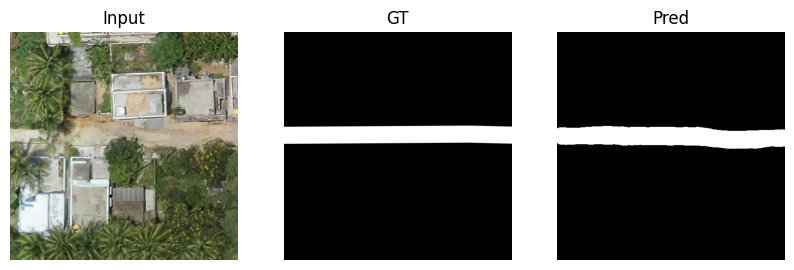

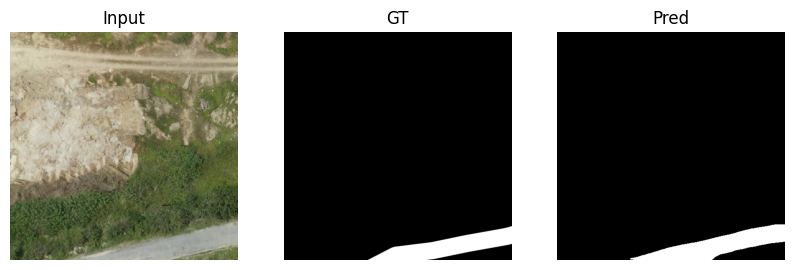

In [ ]:
# CELL 7 — quick inference visualization (optional)
import matplotlib.pyplot as plt
from random import randint

# pick fold 1 best model (change if needed)
best_model_path = os.path.join(GEOTILE_DIR, "unet_best_fold1.pth")
model = make_model(backbone="resnet34", dropout=0.0)  # dropout=0 for inference
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
model.eval()

# sample few tiles from val set of fold 1
# we use the KFold split again to fetch val indices for fold 1
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
_, val_idx = list(kf.split(np.arange(N_TILES)))[0]  # fold 1 val

for _ in range(3):
    i = val_idx[randint(0, len(val_idx)-1)]
    img = X_mem[i]
    msk = Y_mem[i]
    # prepare same as dataset
    ds = LazyTilesDataset([i], mode="val")
    xb, yb = ds[0]
    xb = xb.unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pred = torch.sigmoid(model(xb)).squeeze().cpu().numpy()
    pred_bin = (pred > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.imshow((xb.squeeze().permute(1,2,0).cpu().numpy()*255).astype(np.uint8)); plt.title("Input"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(yb.squeeze().cpu().numpy(), cmap="gray"); plt.title("GT"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(pred_bin, cmap="gray"); plt.title("Pred"); plt.axis("off")
    plt.show()

In [ ]:
# ============================================================
# BLOCK A — Load saved models + utilities for evaluation
# ============================================================

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import KFold
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Evaluation device:", DEVICE)

BASE = "/content/drive/MyDrive/geotile"

# Load datasets again (not in RAM, only on call)
X_full = np.load(f"{BASE}/X_train_tiles.npy", mmap_mode="r")
Y_full = np.load(f"{BASE}/Y_train_tiles.npy", mmap_mode="r")

print("Loaded tiles:", X_full.shape, Y_full.shape)

# Recreate validation transforms
valid_transform = A.Compose([ToTensorV2()])

class EvalDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        msk = self.Y[idx]

        aug = valid_transform(image=img, mask=msk)
        image = aug["image"].float() / 255.0
        mask = aug["mask"].unsqueeze(0).float() / 255.0
        return image, mask

# Same model as before (for loading)
class UNetWithDropout(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        self.encoder = smp.encoders.get_encoder(
            "resnet34", weights="imagenet", in_channels=3
        )
        self.decoder = smp.decoders.unet.decoder.UnetDecoder(
            encoder_channels=self.encoder.out_channels,
            decoder_channels=[256, 128, 64, 32, 16]
        )
        self.segmentation_head = smp.base.heads.SegmentationHead(
            in_channels=16, out_channels=1, activation=None
        )
        self.drop = nn.Dropout2d(dropout)

    def forward(self, x):
        feats = self.encoder(x)
        feats = [self.drop(f) for f in feats]
        dec = self.decoder(*feats)
        mask = self.segmentation_head(dec)
        return mask

# Metric calculator
def compute_metrics_np(pred, true):
    pred_bin = (pred > 0.5).astype(np.uint8)
    true_bin = (true > 0.5).astype(np.uint8)

    tp = (pred_bin * true_bin).sum()
    fp = (pred_bin * (1 - true_bin)).sum()
    fn = ((1 - pred_bin) * true_bin).sum()
    tn = ((1 - pred_bin) * (1 - true_bin)).sum()

    eps = 1e-6
    return {
        "Accuracy": (tp + tn) / (tp + tn + fp + fn + eps),
        "Precision": tp / (tp + fp + eps),
        "Recall": tp / (tp + fn + eps),
        "F1": (2 * tp) / (2 * tp + fp + fn + eps),
        "IoU": tp / (tp + fp + fn + eps),
        "Dice": (2 * tp) / (2 * tp + fp + fn + eps),
        "Specificity": tn / (tn + fp + eps)
    }

print("BLOCK A loaded successfully.")

Evaluation device: cuda
Loaded tiles: (587, 512, 512, 3) (587, 512, 512, 1)
BLOCK A loaded successfully.


   fold  best_epoch  train_loss  val_loss  train_Accuracy  train_Precision  \
0     1          28    0.163642  0.122025        0.982837         0.830576   
1     2          29    0.177594  0.125640        0.982699         0.831021   
2     3          28    0.201408  0.133730        0.978809         0.799876   
3     4          30    0.151040  0.125024        0.984402         0.856398   
4     5          28    0.154144  0.139551        0.981631         0.854282   

   train_Recall  train_F1  train_IoU  train_Dice  train_Specificity  \
0      0.844801  0.837628   0.720620    0.837628           0.990470   
1      0.839913  0.835443   0.717391    0.835443           0.990577   
2      0.793465  0.796658   0.662037    0.796658           0.989041   
3      0.845994  0.851164   0.740893    0.851164           0.992105   
4      0.781823  0.816448   0.689829    0.816448           0.992647   

   val_Accuracy  val_Precision  val_Recall    val_F1   val_IoU  val_Dice  \
0      0.985937       0.8484

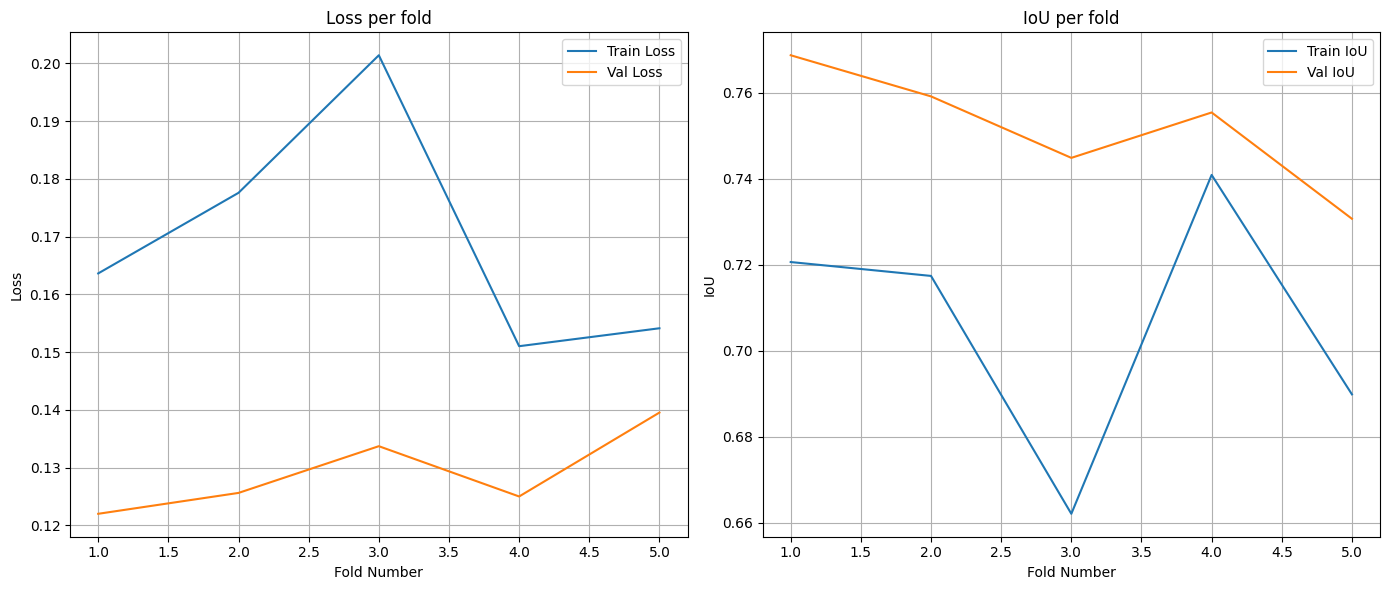

In [ ]:
# ============================================================
# BLOCK B — Training curves from kfold_summary.csv
# ============================================================

csv_path = f"{BASE}/kfold_summary.csv"
df = pd.read_csv(csv_path)

print(df.head())

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(df['fold'], df['train_loss'], label='Train Loss')
plt.plot(df['fold'], df['val_loss'], label='Val Loss')
plt.title("Loss per fold")
plt.xlabel("Fold Number")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(df['fold'], df['train_IoU'], label='Train IoU')
plt.plot(df['fold'], df['val_IoU'], label='Val IoU')
plt.title("IoU per fold")
plt.xlabel("Fold Number")
plt.ylabel("IoU")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# BLOCK C — Final cross-validation evaluation using saved models
# ============================================================

import segmentation_models_pytorch as smp

# ---- USE THE SAME MODEL DEFINITION AS TRAINING ----
class UNetWithDropout(nn.Module):
    def __init__(self, backbone="resnet34", dropout=0.3):
        super().__init__()
        self.net = smp.Unet(
            encoder_name=backbone,
            encoder_weights=None,      # DO NOT load imagenet again
            in_channels=3,
            classes=1
        )
        self.dropout = nn.Dropout2d(dropout)

    def forward(self, x):
        feats = self.net.encoder(x)
        dec = self.net.decoder(*feats)
        dec = self.dropout(dec)
        return self.net.segmentation_head(dec)

print("Correct evaluation model initialized.")

from torch.utils.data import DataLoader
from tqdm import tqdm

fold = 1
FINAL_RESULTS = []

print("\n=== FINAL CROSS-VALIDATION METRICS ===")

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X_full):
    print(f"\nEvaluating Fold {fold}...")

    # Load model exactly like training
    model = UNetWithDropout(backbone="resnet34", dropout=0.3).to(DEVICE)

    model_path = f"{BASE}/unet_best_fold{fold}.pth"
    model.load_state_dict(torch.load(model_path, map_location=DEVICE), strict=True)
    model.eval()

    val_ds = EvalDataset(X_full[val_idx], Y_full[val_idx])
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)

    fold_metrics = []

    for xb, yb in tqdm(val_loader):
        xb = xb.to(DEVICE)
        with torch.no_grad():
            pred = torch.sigmoid(model(xb)).cpu().numpy()[0,0]
        true = yb.numpy()[0,0]

        metrics = compute_metrics_np(pred, true)
        fold_metrics.append(list(metrics.values()))

    fold_metrics = np.array(fold_metrics)
    avg = fold_metrics.mean(axis=0)

    names = ["Accuracy","Precision","Recall","F1","IoU","Dice","Specificity"]
    print("\n".join([f"{n}: {v:.4f}" for n,v in zip(names, avg)]))

    FINAL_RESULTS.append(avg)
    fold += 1

print("\n✓ All folds evaluated successfully.")

Correct evaluation model initialized.

=== FINAL CROSS-VALIDATION METRICS ===

Evaluating Fold 1...


100%|██████████| 118/118 [01:06<00:00,  1.78it/s]


Accuracy: 0.8986
Precision: 0.0537
Recall: 0.0555
F1: 0.0543
IoU: 0.0283
Dice: 0.0543
Specificity: 0.9448

Evaluating Fold 2...


100%|██████████| 118/118 [01:05<00:00,  1.80it/s]


Accuracy: 0.8992
Precision: 0.0616
Recall: 0.0627
F1: 0.0620
IoU: 0.0323
Dice: 0.0620
Specificity: 0.9454

Evaluating Fold 3...


100%|██████████| 117/117 [01:06<00:00,  1.77it/s]


Accuracy: 0.8982
Precision: 0.0595
Recall: 0.0619
F1: 0.0585
IoU: 0.0305
Dice: 0.0585
Specificity: 0.9445

Evaluating Fold 4...


100%|██████████| 117/117 [01:06<00:00,  1.75it/s]


Accuracy: 0.9041
Precision: 0.0579
Recall: 0.0586
F1: 0.0571
IoU: 0.0297
Dice: 0.0571
Specificity: 0.9490

Evaluating Fold 5...


100%|██████████| 117/117 [01:07<00:00,  1.73it/s]

Accuracy: 0.8989
Precision: 0.0594
Recall: 0.0599
F1: 0.0593
IoU: 0.0309
Dice: 0.0593
Specificity: 0.9457

✓ All folds evaluated successfully.


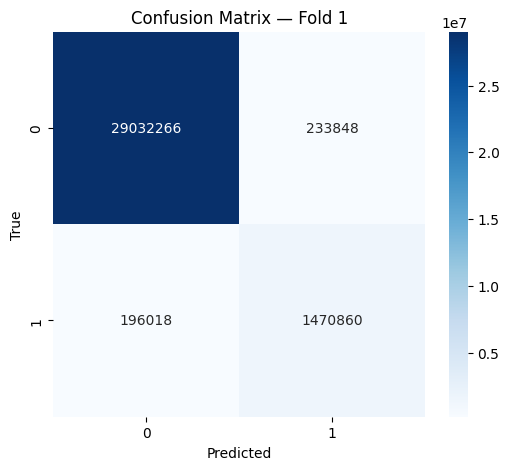

In [ ]:
# ============================================================
# BLOCK E — Confusion Matrix for a fold
# ============================================================

from sklearn.metrics import confusion_matrix

fold_to_show = 1
_, val_idx = list(kf.split(X_full))[fold_to_show-1]

y_true_all = []
y_pred_all = []

model = UNetWithDropout(dropout=0.0).to(DEVICE)
model.load_state_dict(torch.load(f"{BASE}/unet_best_fold{fold_to_show}.pth"))
model.eval()

for i in val_idx:
    img = X_full[i]
    msk = Y_full[i]

    ds = EvalDataset([img], [msk])
    img_t, mask_t = ds[0]
    xb = img_t.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = torch.sigmoid(model(xb)).squeeze().cpu().numpy()

    y_pred_all.extend((pred > 0.5).astype(np.uint8).ravel())
    y_true_all.extend((mask_t.numpy().squeeze() > 0.5).astype(np.uint8).ravel())

cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — Fold {fold_to_show}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# ============================================================
# BLOCK F — Save model architecture diagram (torchsummary)
# ============================================================

!pip install torchsummary

from torchsummary import summary

model = UNetWithDropout(dropout=0.0).to(DEVICE)
summary(model, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
       BasicBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

Overlay visualization starting...
Using device: cuda
Loaded tiles: (587, 512, 512, 3) (587, 512, 512, 1)
Loading model from: /content/drive/MyDrive/geotile/unet_best_fold1.pth
Model loaded successfully!


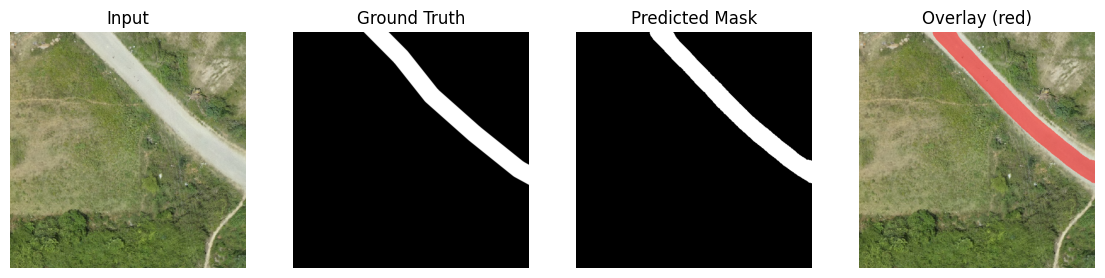

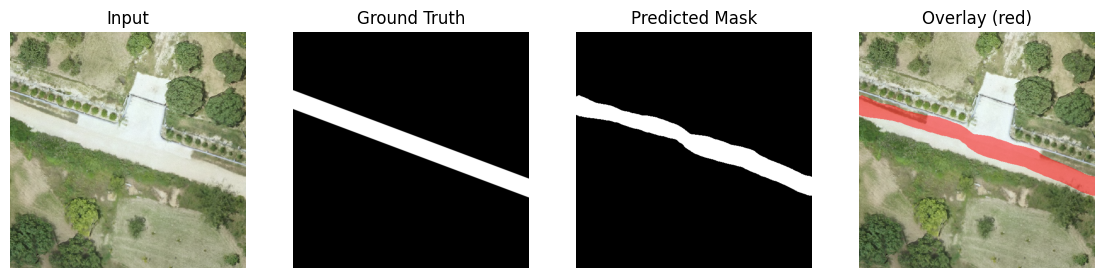

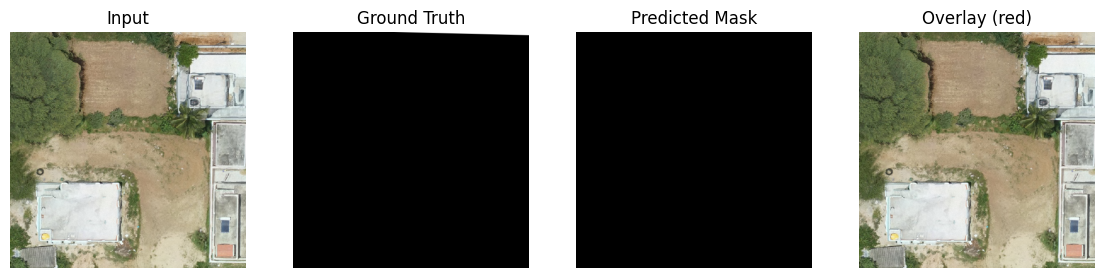

Overlay visualization complete.


In [ ]:
# ============================================================
# OVERLAY VISUALIZATION — FIXED FOR TRAINED MODEL ARCHITECTURE
# ============================================================

print("Overlay visualization starting...")

import os
import numpy as np
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

# ------------------------------
# DEVICE
# ------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# ------------------------------
# LOAD DATA (same as training)
# ------------------------------
BASE = "/content/drive/MyDrive/geotile"

X = np.load(f"{BASE}/X_train_tiles.npy")
Y = np.load(f"{BASE}/Y_train_tiles.npy")

print("Loaded tiles:", X.shape, Y.shape)

# -----------------------------------------------------------
# CORRECT TRAINING ARCHITECTURE (MATCHES SAVED CHECKPOINT)
# -----------------------------------------------------------
class UNetWithDropout(nn.Module):
    def __init__(self, backbone="resnet34", dropout=0.0):
        super().__init__()
        self.net = smp.Unet(
            encoder_name=backbone,
            encoder_weights="imagenet",
            in_channels=3,
            classes=1
        )
        self.drop = nn.Dropout2d(dropout)

    def forward(self, x):
        feats = self.net.encoder(x)
        dec = self.net.decoder(*feats)
        dec = self.drop(dec)
        return self.net.segmentation_head(dec)


def make_model():
    return UNetWithDropout(backbone="resnet34", dropout=0.0).to(DEVICE)


# ------------------------------
# LOAD MODEL (fold 1)
# ------------------------------
model_path = f"{BASE}/unet_best_fold1.pth"
print("Loading model from:", model_path)

model = make_model()
state = torch.load(model_path, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

print("Model loaded successfully!")

# ------------------------------
# OVERLAY FUNCTION
# ------------------------------
def overlay_mask(image, mask, alpha=0.5):
    """return overlay RGB image"""
    overlay = image.copy()
    red_mask = np.zeros_like(image)
    red_mask[..., 0] = 255  # red channel
    mask_3ch = np.stack([mask]*3, axis=-1)

    overlay = overlay * (1 - alpha * mask_3ch) + red_mask * (alpha * mask_3ch)
    return overlay.astype(np.uint8)


# ------------------------------
# RANDOM VISUALIZATION
# ------------------------------
import random

for _ in range(3):
    idx = random.randint(0, len(X)-1)

    img = X[idx]              # (512,512,3)
    true_mask = Y[idx][...,0] # (512,512)

    # Prepare for model
    img_tensor = torch.tensor(img/255.0, dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(DEVICE)

    # Prediction
    with torch.no_grad():
        pred = torch.sigmoid(model(img_tensor)).cpu().numpy()[0,0]

    pred_bin = (pred > 0.5).astype(np.uint8)

    overlay = overlay_mask(img.astype(np.uint8), pred_bin)

    # ---------------------------
    # Display
    # ---------------------------
    plt.figure(figsize=(14,4))

    plt.subplot(1,4,1)
    plt.imshow(img.astype(np.uint8))
    plt.title("Input")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(true_mask, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(pred_bin, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(overlay)
    plt.title("Overlay (red)")
    plt.axis("off")

    plt.show()

print("Overlay visualization complete.")